***Approaches to numerically differentiating the magnetometer readings from a spinning satellite***

Alaric Sanders 2021

First we set up some groundwork:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()

In [3]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b = -axis[0]*np.sin(theta / 2.0)
    c = -axis[1]*np.sin(theta / 2.0)
    d = -axis[2]*np.sin(theta / 2.0)
    
    aa, bb, cc ,dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


In [4]:
class fake_magnetometer:
    def __init__(self, samp_freq, t_stdev, y_stdev,
                     rot_freq = 1.,  num_periods=1, axis=(0, 0, 1), B0 = (1, 0, 0)):
        self.buflen  = int(samp_freq*num_periods/rot_freq)+1
        self.y_stdev = y_stdev
        self.t_stdev = t_stdev
        self.axis = np.array(axis)
        self.B0 = np.array(B0)
        if type(rot_freq) in (float, int):
            def f(T):
                return rot_freq
            self.rot_freq_generator = f
        elif type(rot_freq) is function:
            self.rot_freq_generator = rot_freq
        """
        Generates a signal for rotation in 3D about 'axis' at a rate of 'rot_freq' Hz.
        @param samp_freq sampling frequency, units of Hz
        @param t_stdev standard deviation of sampling times
        @param y_stdev standard deviation of field reading
        @param slowdown Dimensionless (constant) rate at which speed decreases.
        """
        
        # consistently, linearly spaced time points
        self.T_clean = np.linspace(0, num_periods, self.buflen)
        self.generate()

    def generate(self):
        # add some noise to simulate timer instability
        self.T = self.T_clean+rng.standard_normal(self.buflen)*self.t_stdev*(self.T_clean[1]-self.T_clean[0])
        self.T = np.sort(self.T)
        
        self.rot_freq = self.rot_freq_generator(self.T)
        # B(t) = R(n, t)*B0
        self.B = np.dot(
            rotation_matrix(self.axis, 
                            self.T*2*np.pi*self.rot_freq).T, 
            self.B0)
        self.B += rng.standard_normal((self.buflen,3))*self.y_stdev
        

    
    def get_data(self):
        # add some magnetometer noise
        return (self.T, self.B)
    
    def get_sensorlike(self, bufsize, offset=0):
        if bufsize > self.buflen:
            bufsize=self.buflen
        # populates a cyclic array with sensor data, assuming buffer size is bufsize.
        # e.g. returns B such that the n'th reading is accessed as 
        # B[(offset+n)%bufsize]

            
        return (self.T[offset:offset+bufsize], self.B[offset:offset+bufsize,:])

        


**Generating data with a fake magnetometer**
- Parameter F0 dictates the sampling rate (Hz). Since the default rotation rate is 1Hz, this corresponds to the number of samples per period.
- Parameters following are noise in t and y respectively. (Note that t gets sorted to ensure that it does not go back in time!)
- Rotation axis should be self explanatory.
- Two objects, 'perfect' and 'noisy', where the variance of 'perfect' is set to zero to compare against the noisy data.

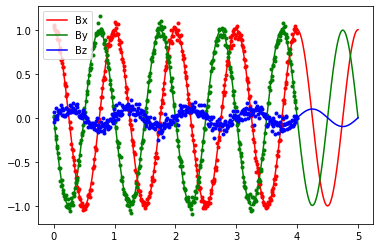

In [5]:
F0 = 100
    
rotation_axis =  [0, 0.1, 1]
    
perfect = fake_magnetometer(F0, 0, 0, num_periods=5, axis=rotation_axis)
noisy = fake_magnetometer(F0, 1e-2, 5e-2, num_periods=5, axis=rotation_axis)

plt.gca().set_prop_cycle('c',['red','green','blue'])

Tp, Yp = perfect.get_data()
T, Y = noisy.get_sensorlike(400)
plt.plot(Tp, Yp,'-')
plt.plot(T, Y,'.')
plt.legend(['Bx','By','Bz'])

**The Problem:** Naive numerical derivatives amplify noise by a factor of the timestep.
Inspired by the analytic formula, we may try this:

$$ \dot{B}_n = \frac{B_n-B_{n-1}}{\Delta t} $$

However, it is far too noisy to use for control (see below).

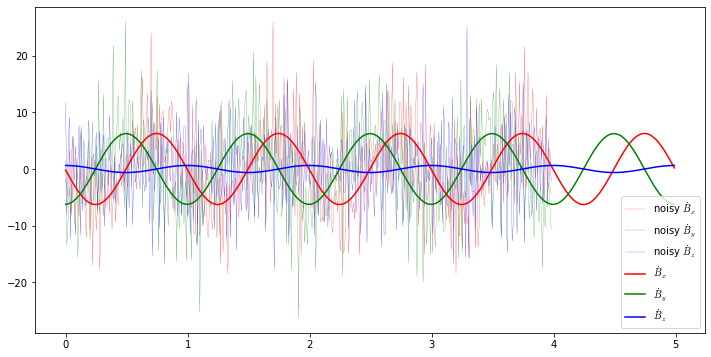

In [6]:
fig = plt.figure(figsize = (12,6))
plt.gca().set_prop_cycle('c',['red','green','blue'])


for a in range(3):
    plt.plot(T[:-1], (Y[1:,a]-Y[:-1,a])/(T[1:]-T[:-1]), lw = '0.2')

for a in range(3):
    plt.plot(Tp[:-1], (Yp[1:,a]-Yp[:-1,a])/(Tp[1:]-Tp[:-1]))

    
plt.legend(['noisy $\dot{B}_x$','noisy $\dot{B}_y$','noisy $\dot{B}_z$', '$\dot{B}_x$','$\dot{B}_y$','$\dot{B}_z$'])

**Approach 1: Exponential Smoothing**

The code below takes the time series $t_n, B_n$ and calculates the "smoothed" quantity $\bar{B}_n$ as follows:

$$\bar{B}_n = \frac{1}{W_n}\sum_{i=0}^N B_{n-i} \exp(t_{n-i}-t_n)$$

where the normalisation factor $W_n = \sum_{i=0}^N \exp(t_{n-i}-t_n)$.

This smooths the noise in the B signals, and gives it a well behaved derivative.

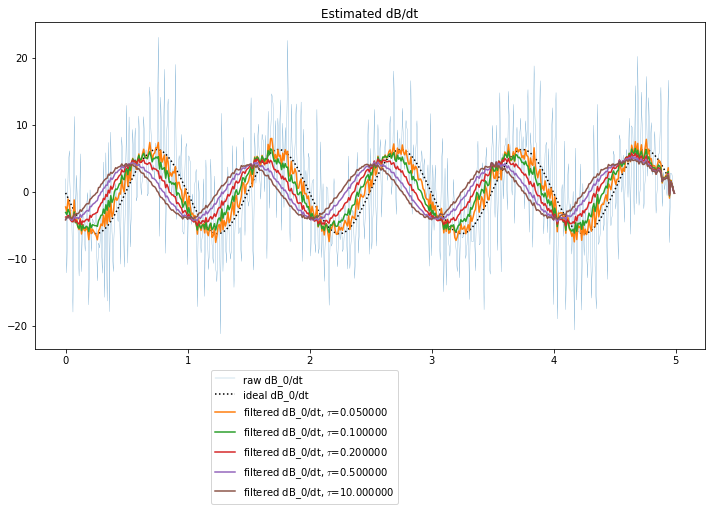

In [7]:
fig = plt.figure(figsize = (12,6))
# plt.gca().set_prop_cycle('c',['red','green','blue'])

plt.title('Estimated dB/dt')



# mag = fale_magnetometer(samples_per_period, t_noise, y_noise, **kwargs)
# Adjust these lines to change the size of the noise.
perfect = fake_magnetometer(100, 0, 0, num_periods=5, axis=rotation_axis)
noisy = fake_magnetometer(100, 1e-2, 5e-2, num_periods=5, axis=rotation_axis)

domain=500
T, Y = noisy.get_sensorlike(domain+1)
Tp, Yp = perfect.get_sensorlike(domain+1)



samples = 50


DIMS = [0]

# plots the naive derivative of noisy data
for a in DIMS:
    plt.plot(T[:domain], (Y[1:,a]-Y[:-1,a])/(T[1:]-T[:-1]),label='raw dB_%d/dt'%a,lw = '0.2')

# plots the naive derivative of noise-free data
for a in DIMS:
    plt.plot(Tp[:domain], (Yp[1:,a]-Yp[:-1,a])/(Tp[1:]-Tp[:-1]),'k:',label='ideal dB_%d/dt'%a)

    
def exp_smooth(t, y, tau):
    y1 = np.dot(y, np.exp(-(t-t[0])/tau))
    return y1 / np.sum(np.exp(-(t-t[0])/tau)) 
    
    
for filter_tau in [0.05,0.1,0.2,0.5,10]:
# for filter_tau in [0.1]:
    

    for a in DIMS:
        dB = np.zeros(domain)
        for i in range(domain):
            t, y = noisy.get_sensorlike(samples+1, i)
            
            y1 = exp_smooth(t[:-1], y[:-1,a], filter_tau)
            y0 = exp_smooth(t[1:], y[1:,a], filter_tau)
            
            dB[i] = (y0-y1)/(t[1]-t[0])
        plt.plot(T[:domain],dB, label=r"filtered dB_%d/dt, $\tau$=%f"%(a,filter_tau))
              
# plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(0.55, -0.05))

The adjustable parameter $\tau$ lets us tune the degree of smoothing.
There is an uncomfortable trade-off here: higher values of $\tau$ make smoother graphs, but also introduce a phase offset to the curve. Further, the exponential smoothing effectively lowers the Nyquist frequency. Play around with different parameters to see how this changes things.

**Approach 2: Autocorrelation + phase** 

Theoretically, we know that a model of the form $B(t) = B_0 \sin(\omega t + \phi)$
*should* fit the data we have. However, nonlinear least squares is slow and unreliable: definitely not appropriate for 'space grade' stuff.

However, if we have several oscillations, it *is* possible to estimate $\omega$ independently via autocorrelaiton, $A_k = \sum_t B_t B_{t+k}$.

This is *very* robust to noise, capable of giving useful results when the noise is same size as the signal!
- Based on the first peak ($T = 1$), we have a very accurate estimate of the rotation period!

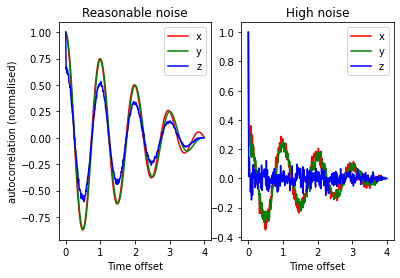

In [12]:
# low noise
noisy = fake_magnetometer(F0, 1e-2, 5e-2, num_periods=5, axis=rotation_axis)
noisy2 = fake_magnetometer(F0, 1e-3, 1, num_periods=20, axis=rotation_axis)
T, Y = noisy.get_sensorlike(400)
T2, Y2 = noisy2.get_sensorlike(400)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_xlabel('Time offset')
ax2.set_xlabel('Time offset')
ax1.set_ylabel('autocorrelation (normalised)')
ax1.set_prop_cycle('c',['red','green','blue'])
ax2.set_prop_cycle('c',['red','green','blue'])
ax1.set_title('Reasonable noise')
ax2.set_title('High noise')

def autocorr(z):
    result = np.correlate(z,z, mode='full')
    return result[result.size//2:]/result[result.size//2]
    

for a in range(3):
    ax1.plot(T, autocorr(Y[:,a]))
    ax1.legend(['x','y','z'])
    
    ax2.plot(T2, autocorr(Y2[:,a]))
    ax2.legend(['x','y','z'])

It doesn't work when rotating slowly though.
- All three traces should be the same, but x has a systematic bias in it!

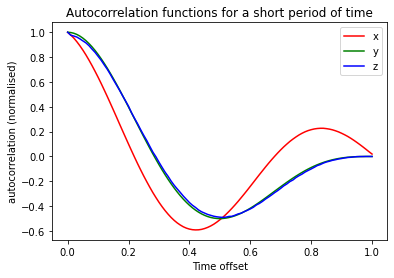

In [16]:
noisy = fake_magnetometer(F0, 1e-3, 1e-2, num_periods=1, axis=rotation_axis)
T, Y = noisy.get_sensorlike(400)
plt.gca().set_prop_cycle('c',['red','green','blue'])
plt.title('Autocorrelation functions for a short period of time')
plt.ylabel('autocorrelation (normalised)')
plt.xlabel('Time offset')
for a in range(3):
    plt.plot(T, autocorr(Y[:,a]))
    plt.legend(['x','y','z'])

WIP: recover the phase $\phi$ based on knowledge of $\omega$, use this for very accurate B dot estimation/rotational kinematics.

**Approach 3: Local polynomial approximation**

The idea: Taylor approximate a sample of data over a short time period, and get the derivative of the Taylor polynomial.

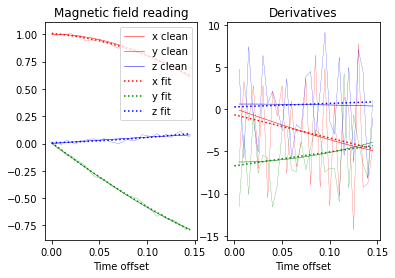

In [57]:
from numpy.polynomial import Polynomial

perfect = fake_magnetometer(200, 0, 0, num_periods=5, axis=rotation_axis)
noisy = fake_magnetometer(200, 1e-2, 2e-2, num_periods=5, axis=rotation_axis)


fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_xlabel('Time offset')
ax2.set_xlabel('Time offset')
ax1.set_prop_cycle('c',['red','green','blue'])
ax2.set_prop_cycle('c',['red','green','blue'])
ax1.set_title('Magnetic field reading')
ax2.set_title('Derivatives')

num_points = 30

Tp, Yp = perfect.get_sensorlike(num_points)
T, Y = noisy.get_sensorlike(num_points)

# plot the clean variables
for a, d in zip([0,1,2],'x y z'.split()):
    ax1.plot(Tp, Yp[:,a],label="%s clean"%d,lw=0.5)
    ax2.plot(Tp[1:], (Yp[:-1,a]-Yp[1:,a])/(Tp[:-1]-Tp[1:]),label="%s clean"%d,lw=0.5)

# plot the noisy readings
for a, d in zip([0,1,2],'x y z'.split()):
    ax1.plot(T, Y[:,a],lw=0.2)
    ax2.plot(T[1:], (Y[:-1,a]-Y[1:,a])/(T[:-1]-T[1:]),lw=0.2)

# plot the best fits
for a, d in zip([0,1,2],'x y z'.split()):
    # do a quadratic fit
    p = Polynomial.fit(T,Y[:,a], deg=2)
    ax1.plot(T, p(T),':',label="%s fit"%d)
    ax2.plot(T, p.deriv()(T),':',label="%s fit"%d)

ax1.legend()

**Limitations**
- Fails if too few data  points are present
- Fails if curvature of graphs is too high